In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
def jac_to_ic(rg,rp,theta,m1,m2,m3):
    
    thrad=np.radians(theta)

    mred2 = m2/(m2+m3)
    mred3 = m3/(m2+m3)

    r12=np.sqrt(rg*rg + mred3*mred3*rp*rp + 2.0*rg*mred3*rp*np.cos(thrad))
    r13=np.sqrt(rg*rg + mred2*mred2*rp*rp - 2.0*rg*mred2*rp*np.cos(thrad))
    r23=rp

    return r12,r13,r23

def ic_to_jac(r12,r13,r23,m1,m2,m3):

    mred2 = m2/(m1+m2)
    d1 = mred2*r13
    cbeta = (r12*r12+r13*r13-r23*r23)/(2.0*r12*r13)

    rp = r13
    rg = np.sqrt(r12*r12+d1*d1-2.0*r12*d1*cbeta)
    ctheta = (r12*r12-d1*d1-rg*rg)/(-2.0*rg*d1)
    theta = np.degrees(np.arccos(ctheta))

    return rg,rp,theta

def transform_coords(rg,rp,theta,m1,m2,m3):

    r12,r13,r23=jac_to_ic(rg,rp,theta,m1,m2,m3)
    rgp,rpp,thetap=ic_to_jac(r12,r13,r23,m1,m2,m3)

    return rgp,rpp,thetap

In [5]:
print(transform_coords(2.65,1.4,90,30.9737620,2.0141017778,2.0141017778))

(np.float64(2.5966922514026716), np.float64(2.7408940147331493), np.float64(148.58264539291366))


In [3]:
path_ex = "/home/jorgebdelafuente/Doctorado/Quantics/PH2p_1TApp/exact_test/"
# psi_twocoords = np.loadtxt(path_ex+"grid_test.dat")
# rpgrid = np.loadtxt(path_ex+"rpgrid.dat",skiprows=11)[:,1]
# rggrid = np.loadtxt(path_ex+"rggrid.dat",skiprows=11)[:,1]
# thgrid = np.loadtxt(path_ex+"thgrid.dat",skiprows=11)[:,1]
# print(rpgrid)

In [6]:
blocks = []

with open(path_ex+"grid_test.dat") as f:
    current_block = []
    for line in f:
        s = line.strip()
        if not s: 
            if current_block:   
                blocks.append(current_block)
                current_block = []
        else:
            current_block.append([float(x) for x in s.split()])
    if current_block:
        blocks.append(current_block)

In [7]:
print(blocks[0][0][3],blocks[0][0][4],blocks[0][0][5],30.9737620,2.0141017778,2.0141017778)
print(transform_coords(blocks[0][0][3],blocks[0][0][4],blocks[0][0][5],30.9737620,2.0141017778,2.0141017778))

0.5 0.1 176.22514945 30.973762 2.0141017778 2.0141017778
(np.float64(0.4165490310721345), np.float64(0.5499013758157536), np.float64(179.17658353017674))


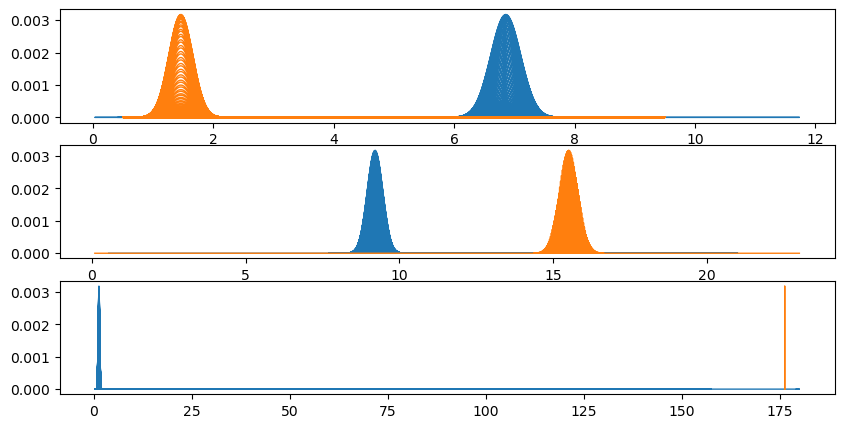

In [24]:
fig, ax = plt.subplots(3,figsize=(10,5))

test=np.array(blocks[00])
norm = np.sqrt(test[:,6]*test[:,6] + test[:,7]*test[:,7])
# norm = test[:,6]
rpt,rgt,tht = transform_coords(test[:,3],test[:,4],test[:,5],30.9737620,2.0141017778,2.0141017778)
ax[0].plot(test[:,0],norm,lw=1)
# ax[0].plot(rpt,norm,lw=1,alpha=0.15)
ax[0].plot(test[:,3],norm,lw=1)

ax[1].plot(test[:,1],norm,lw=1)
# ax[1].plot(rgt,norm,lw=1,alpha=0.15)
ax[1].plot(test[:,4],norm,lw=1)

ax[2].plot(test[:,2],norm,lw=1)
# ax[2].plot(tht,norm,lw=1,alpha=0.15)
ax[2].plot(test[:,5],norm,lw=1)

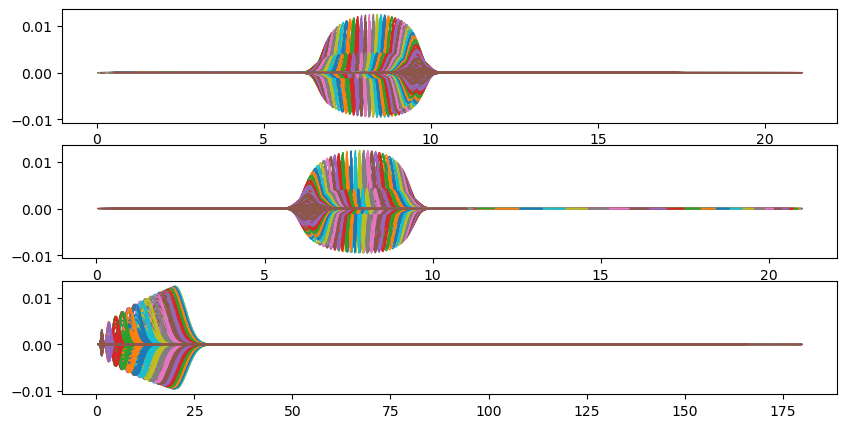

In [10]:
fig1, ax1 = plt.subplots(3,figsize=(10,5))

for i in range(len(blocks)):
    test=np.array(blocks[i])
    # norm = np.sqrt(test[:,6]*test[:,6] + test[:,7]*test[:,7])
    norm = test[:,6]
    ax1[0].plot(test[:,0],norm,lw=1)
    ax1[1].plot(test[:,1],norm,lw=1)
    ax1[2].plot(test[:,2],norm,lw=1)

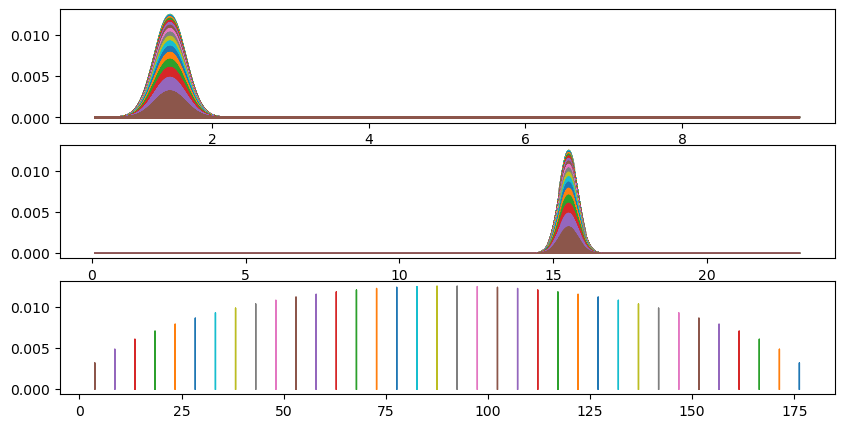

In [27]:
fig1, ax1 = plt.subplots(3,figsize=(10,5))

for i in range(len(blocks)):
    test=np.array(blocks[i])
    norm = np.sqrt(test[:,6]*test[:,6] + test[:,7]*test[:,7])
    # norm = test[:,6]
    ax1[0].plot(test[:,3],norm,lw=1)
    ax1[1].plot(test[:,4],norm,lw=1)
    ax1[2].plot(test[:,5],norm,lw=1)

In [13]:
def ho_modes(r, mu, omega, r0=0.0, hbar=1.0, nv=10):
    """
    Devuelve (E, phi) con
    E: (nv,) energías ordenadas
    phi: (nr, nv) eigenmodos normalizados en rejilla uniforme sin pesos (sum |phi|^2 * dr = 1)
    """
    r = np.asarray(r)
    nr = r.size
    dr = r[1] - r[0]

    # Potencial armónico
    V = 0.5 * mu * omega**2 * (r - r0)**2

    # Laplaciano 1D por diferencias finitas (dirichlet)
    diag = np.full(nr, -2.0)
    off  = np.ones(nr-1)
    D2 = (np.diag(diag) + np.diag(off,1) + np.diag(off,-1)) / (dr**2)

    # Hamiltoniano
    T = -(hbar**2)/(2.0*mu) * D2
    H = T + np.diag(V)

    # Autovalores/autovectores
    E, vecs = np.linalg.eigh(H)

    # Normalizar eigenfunciones con suma discreta sin pesos (sum |phi|^2 * dr = 1)
    phi = vecs[:, :nv]
    norms = np.sqrt((np.abs(phi)**2).sum(axis=0) * dr)
    phi /= norms

    return E[:nv], phi

# ==== Números para D2 reactivos ====
amu_to_me = 1822.888486
mu = 2.00705 * amu_to_me      # ~1837.1
nu_cm = 3115.0 /2               # cm^-1 (test)
omega = nu_cm * 4.556335e-6   # a.u. (Hartree), ~0.0142



[[ 4.05198233e+00 -6.34810571e-04 -6.98782737e-08  4.11476504e+00
  -2.58850951e-04 -2.40685760e-08 -1.12165675e-18  1.97596126e-08]
 [ 4.11476501e+00 -4.90214366e-04 -1.81590063e-08 -4.05198236e+00
   3.41136610e-04  4.18825409e-08  5.04320921e-15 -3.37802067e-04]
 [ 2.40716909e-04  2.71303000e-04  6.57167273e-08 -2.37042606e-04
  -2.01199706e-04 -5.00981764e-08 -2.26755034e-11  5.77493311e+00]
 [ 6.74938506e-04  4.63878224e+00  1.12350091e-03 -1.65370549e-04
  -3.43970193e+00 -8.56412162e-04 -2.85696994e-07 -3.37802067e-04]
 [ 4.23990197e-04  3.43970195e+00  2.57455237e-04  4.04959104e-04
   4.63878203e+00  1.51657366e-03  1.28456371e-03  1.97602793e-08]
 [ 9.42957660e-08  7.65090347e-04 -9.08148028e-04  9.00916317e-08
   1.03221005e-03 -9.08170944e-04 -5.77493284e+00 -1.56835505e-12]
 [ 7.94954214e-08  8.98737338e-04 -4.08372126e+00  2.34276260e-08
   8.94827980e-04 -4.08326708e+00  1.28461047e-03 -3.65731470e-16]
 [ 4.52774646e-08  5.94219697e-04 -4.08326721e+00 -9.58196200e-08
  -

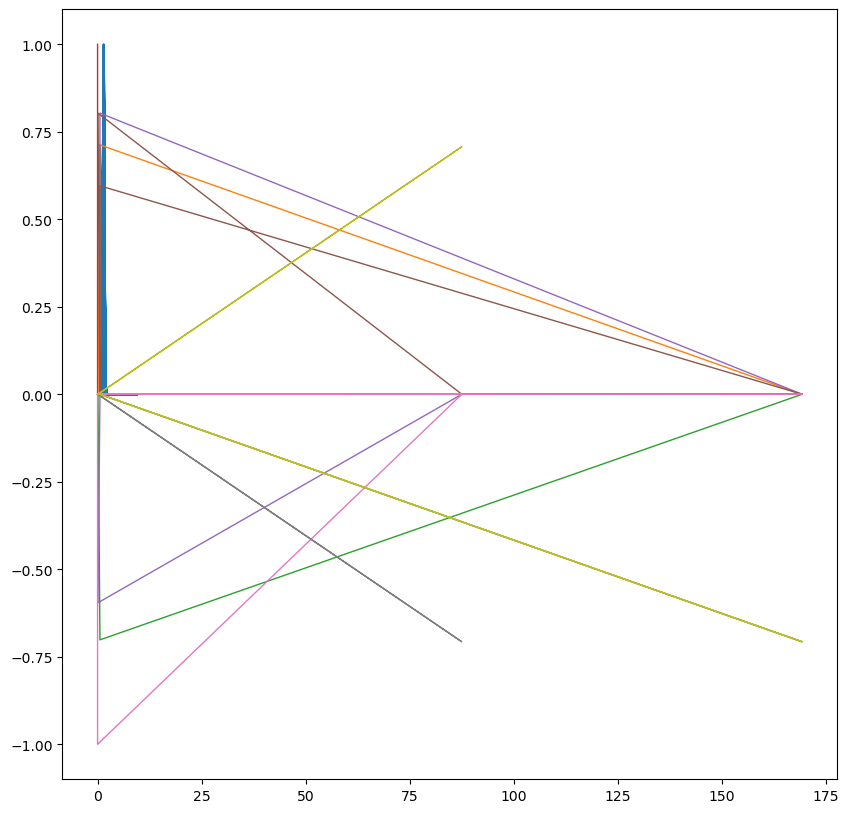

In [26]:
r = np.array(blocks[18][:][3])
R = np.array(blocks[18][:][4])
# r: vector 1D de la rejilla radial (longitud nr) -> NO lo cojas de blocks
E, phi = ho_modes(r, mu=mu, omega=omega, r0=1.4, nv=9)  # phi: (nr, nv)

print(phi)

dr = r[1] - r[0]
dR = R[1] - R[0]

M = np.array(blocks[18])              # M: (nR, nr)
A = M @ phi * dr                # (nR, nv)
Pv = (np.abs(A)**2).sum(axis=0)*dR     # → (nv,)
norm2 = (np.abs(M)**2).sum()*dr*dR        # escalar
frac = Pv / norm2                   # (nv,)
print("Fracciones por v:", frac)
print(sum(frac))

fig2, ax2 = plt.subplots(figsize=(10,10))

normwf = np.sqrt(M[:,6]*M[:,6]+M[:,7]*M[:,7])
ax2.plot(M[:,3],normwf/max(normwf))
maxphi = np.max(phi)
for i in range(len(phi)):
    ax2.plot(r,phi[i,:]/maxphi,lw=1)
# ax2.plot(np.array(blocks[20])[:,4],norm)

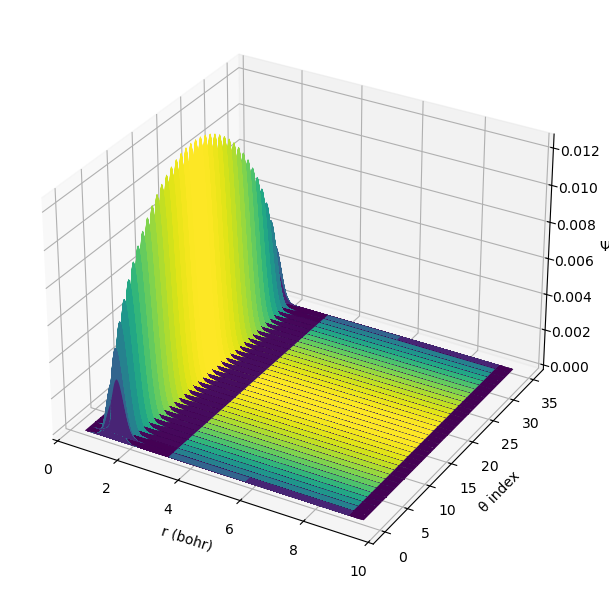

In [53]:
# Convertir a numpy
blocks_array = [np.array(b) for b in blocks]

# Construir rejilla X-Y
# X: r, Y: theta (un valor por bloque)
rp = blocks_array[30][:, 3]                    
# Rg = blocks_array[30][:, 4]                    
theta_vals = np.arange(len(blocks_array))    

Rp, TH = np.meshgrid(rp, theta_vals)
# rp, TH = np.meshgrid(Rg, theta_vals)
# rp, rg = np.meshgrid(rp, Rg)

# Construir matriz Z = psi(r,θ)
Z = np.zeros_like(Rp)
for i, block in enumerate(blocks_array):
    Z[i, :] = np.sqrt(block[:, 6]*block[:,6]+block[:,7]*block[:,7])     # columna que contiene psi

# Graficar superficie
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(Rp, TH, Z, cmap='viridis', edgecolor='none')

ax.set_xlabel("r (bohr)")
ax.set_ylabel("θ index")
ax.set_zlabel("Ψ")

# fig.colorbar(surf, shrink=0.7)
fig.tight_layout()
plt.show()

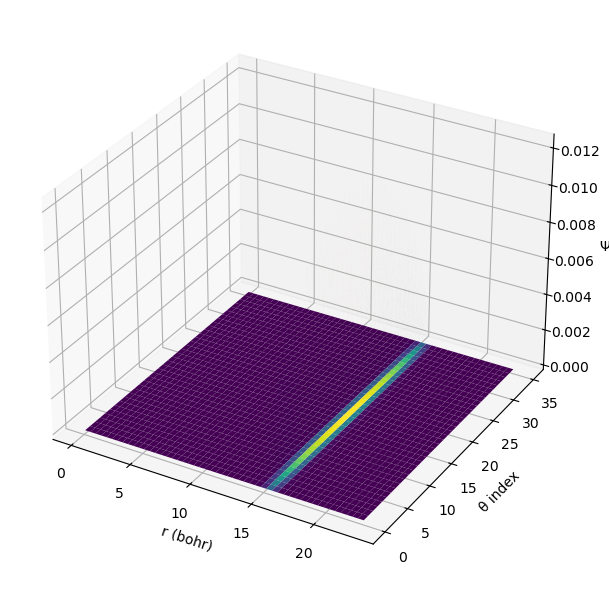

In [54]:
# Convertir a numpy
# Construir rejilla X-Y
# X: r, Y: theta (un valor por bloque)
Rg = blocks_array[30][:, 4]                    
theta_vals = np.arange(len(blocks_array))    

Rp, TH = np.meshgrid(Rg, theta_vals)
# rp, TH = np.meshgrid(Rg, theta_vals)
# rp, rg = np.meshgrid(rp, Rg)

# Construir matriz Z = psi(r,θ)
Z = np.zeros_like(Rp)
for i, block in enumerate(blocks_array):
    Z[i, :] = np.sqrt(block[:, 6]*block[:,6]+block[:,7]*block[:,7])     # columna que contiene psi

# Graficar superficie
fig2 = plt.figure(figsize=(10,6))
ax2 = fig2.add_subplot(111, projection="3d")

surf = ax2.plot_surface(Rp, TH, Z, cmap='viridis', edgecolor='none')

ax2.set_xlabel("r (bohr)")
ax2.set_ylabel("θ index")
ax2.set_zlabel("Ψ")

# fig.colorbar(surf, shrink=0.7)
fig2.tight_layout()
plt.show()

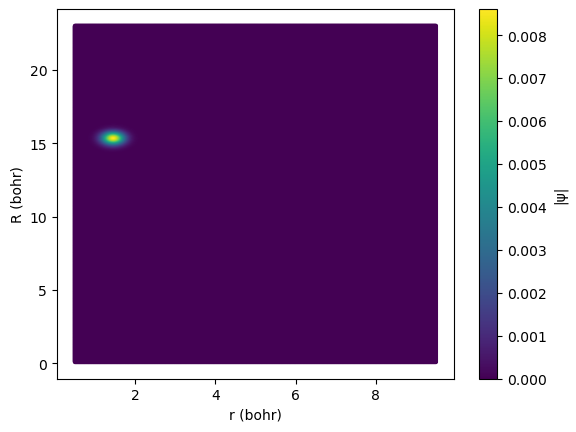

In [57]:
# Convertir a numpy
# Construir rejilla X-Y
# X: r, Y: theta (un valor por bloque)
block = blocks_array[30]
r = block[:, 3]
R = block[:, 4]
psi = np.sqrt(block[:,6]**2 + block[:,7]**2)

plt.scatter(r, R, c=psi, cmap='viridis', s=5)
plt.xlabel("r (bohr)")
plt.ylabel("R (bohr)")
plt.colorbar(label="|ψ|")
plt.show()

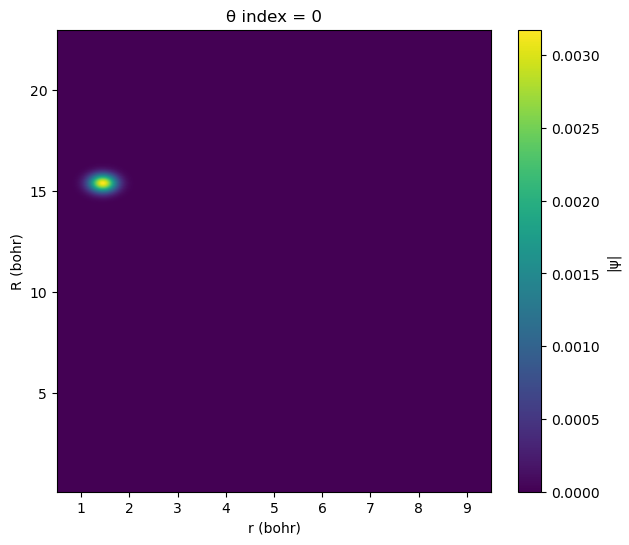

In [64]:

blocks = blocks_array

fig, ax = plt.subplots(figsize=(7,6))

block = blocks[0]
r = block[:,3]
R = block[:,4]
psi = np.sqrt(block[:,6]**2 + block[:,7]**2)

sc = ax.scatter(r, R, c=psi, cmap='viridis', s=5)
ax.set_xlabel("r (bohr)")
ax.set_ylabel("R (bohr)")
cbar = plt.colorbar(sc, ax=ax, label="|ψ|")

ax.set_xlim(r.min(), r.max())
ax.set_ylim(R.min(), R.max())

def update(frame):
    block = blocks[frame]
    r = block[:,3]
    R = block[:,4]
    psi = np.sqrt(block[:,6]**2 + block[:,7]**2)

    sc.set_offsets(np.column_stack((r, R)))
    sc.set_array(psi)
    ax.set_title(f"θ index = {frame}")

    return sc,

anim = FuncAnimation(fig, update, frames=len(blocks), interval=150, blit=False)

anim.save("psi_rR_theta.mp4", fps=10, extra_args=['-vcodec', 'libx264'])

# HTML(anim.to_jshtml())

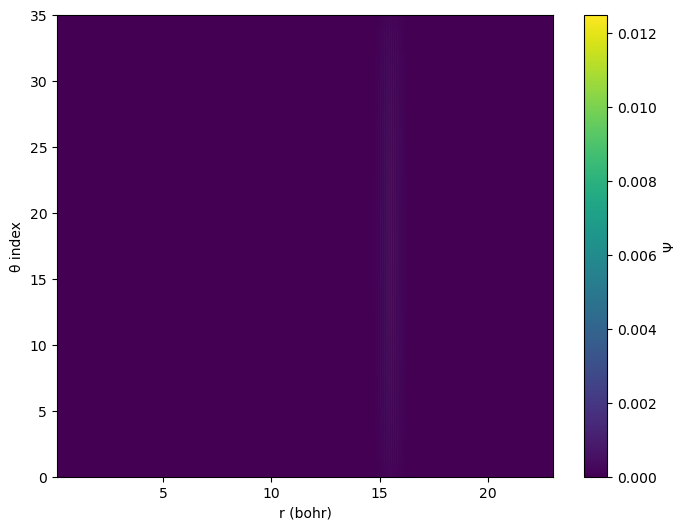

In [50]:
plt.figure(figsize=(8,6))
plt.imshow(Z, aspect='auto', cmap='viridis',
        extent=[Rp.min(), Rp.max(), theta_vals.min(), theta_vals.max()],
        origin='lower')
plt.xlabel("r (bohr)")
plt.ylabel("θ index")
plt.colorbar(label="Ψ")
plt.show()

In [ ]:
# maxgrid = rggrid.shape[0]*rpgrid.shape[0]*thgrid.shape[0]

# old_grid = np.zeros((maxgrid,3))
# new_grid = np.zeros((maxgrid,3))

# idx=0
# for ith,th in enumerate(thgrid):
#     for ig,rg in enumerate(rggrid):
#         for ip,rp in enumerate(rpgrid):
#             idx = ip + (ig)*rpgrid.shape[0] + (ith)*rpgrid.shape[0]*rggrid.shape[0]
#             # print(idx,ip,ig,ith)
#             rgp,rpp,thetap = transform_coords(rg,rp,th,30.9737620,2.0141017778,2.0141017778)
#             old_grid[idx,0], old_grid[idx,1], old_grid[idx,2] = rp,rg,th
#             new_grid[idx,0], new_grid[idx,1], new_grid[idx,2] = rpp,rgp,thetap

# rppmin = new_grid[:,0].min()
# rppmax = new_grid[:,0].max()
# rgpmin = new_grid[:,1].min()
# rgpmax = new_grid[:,1].max()
# thetamin = new_grid[:,2].min()
# thetamax = new_grid[:,2].max()
# # print(rppmin,rppmax,rgpmin,rgpmax,thetamin,thetamax)


In [ ]:
# #FFT dvr New Grid
# dvr_rp = np.linspace(rppmin,rppmax,rpgrid.shape[0])
# dvr_rg = np.linspace(rgpmin,rgpmax,rggrid.shape[0])
# dvr_theta = np.linspace(thetamin,thetamax,thgrid.shape[0])

# thrhld = 1.e-2
# counter = 0
# for ith, th in enumerate(dvr_theta):
#     for ig, rg in enumerate(dvr_rg):
#         for ip, rp in enumerate(dvr_rp):
#             idx = ip + (ig)*dvr_rp.shape[0] + (ith)*dvr_rp.shape[0]*dvr_rg.shape[0]
#             diffrp = abs(rp - new_grid[idx,0])
#             diffrg = abs(rg - new_grid[idx,1])
#             diffrtheta = abs(th - new_grid[idx,2])
#             if abs(diffrp) < thrhld or abs(diffrg) < thrhld or abs(diffrtheta) < thrhld:
#                 counter = counter + 1

# print(counter)

99150
